In [1]:
import glob

from fastai.text import *
# from fastai.callbacks import SaveModelCallback
import sentencepiece as spm #https://github.com/google/sentencepiece

from prod.sp_tok import *
#torch.backends.cudnn.enabled=False #for quant.313v machine.  Not sure why...

In [2]:
PATH = Path('./data/rnn')
sp_model = './all_tweets_es_0609'

defaults.text_spec_tok.append(NL) #add a New Line special char
sp_vocab = Vocab( get_itos(sp_model) )
mycust_tok = CustomTokenizer(SPTokenizer,sp_model,pre_rules=default_rules)

In [3]:
test_df = pd.read_csv('./data/haha_2019_test.csv')
test_df['funniness_average'] = 0
test_df['funniness_average'].iloc[0] = 0.1
test_df['funniness_average'].iloc[1] = 1.2
test_df['funniness_average'].iloc[2] = 3.4
## apply the rules
raw_text = test_df.loc[:,'text']

print("Default Rules:\n",[x.__name__ for x in default_rules],"\n\n")
for rule in default_rules:
    raw_text = raw_text.apply(lambda x: rule(str(x)))    
test_df['new_text'] =  raw_text #tokenizer adds xxbos

data_tst = TextClasDataBunch.from_df(PATH, test_df, test_df,
                               tokenizer=mycust_tok, vocab=sp_vocab,
                               text_cols='new_text', label_cols='funniness_average')

In [4]:
model_wt_fnames = [x.split('/')[-1] for x in glob.glob( str(PATH/'models')+'/haha_regr_0610_mix_fld*.pth')]
len(model_wt_fnames)

7

In [5]:
!grep Reg ./prod/out_regr_tmp200.txt | head -n5 > ./by_seed_reg_perf

In [6]:
!head by_seed_reg_perf

Reg Fold: 0 RndSeed: 460304,0.5666607022285461
Reg Fold: 1 RndSeed: 460304,0.5495392680168152
Reg Fold: 2 RndSeed: 460304,0.5185738801956177
Reg Fold: 3 RndSeed: 460304,0.5452352166175842
Reg Fold: 4 RndSeed: 460304,0.5569671988487244


In [7]:
## be more picky about the models.  Take the top quarter in validation. Does better val -> better test?
valid_perf = pd.read_csv('by_seed_reg_perf', names = ['id','mse'])
valid_perf['rnd_seed'] = valid_perf.id.str.split(':',expand=True).iloc[:,-1].str.strip()
valid_perf['nfold'] = valid_perf.id.str.split(' ',expand=True).iloc[:,2]
valid_perf.head()

,id,mse,rnd_seed,nfold
0,Reg Fold: 0 RndSeed: 460304,0.566661,460304,0
1,Reg Fold: 1 RndSeed: 460304,0.549539,460304,1
2,Reg Fold: 2 RndSeed: 460304,0.518574,460304,2
3,Reg Fold: 3 RndSeed: 460304,0.545235,460304,3
4,Reg Fold: 4 RndSeed: 460304,0.556967,460304,4


Text(0.5, 1.0, 'Freq of mse over all Random Seeds (100) \n Vert line = 25th p-tile')

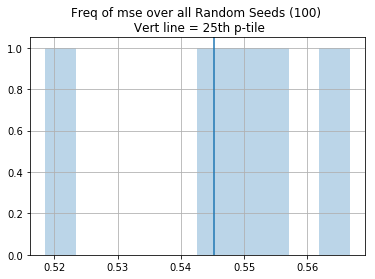

In [8]:
valid_perf.mse.hist(alpha=0.3)
#valid_perf.groupby('rnd_seed')['mse'].mean().hist(alpha=0.3)
plt.axvline(x=valid_perf.mse.quantile(0.25))
#valid_perf[valid_perf.F1 >= valid_perf.F1.quantile(0.75)].F1.hist(alpha=0.3)
plt.title('Freq of mse over all Random Seeds (100) \n Vert line = 25th p-tile')

In [9]:
seed_grouped_F1 = valid_perf.groupby('rnd_seed')['mse'].mean()
selected_seeds = seed_grouped_F1[seed_grouped_F1<=seed_grouped_F1.quantile(1.)].index.values.tolist()
seed_fold_pair = valid_perf[valid_perf.rnd_seed.isin(selected_seeds)].loc[:,['rnd_seed','nfold']].values
model_wt_fnames = []
for (seed,fold) in seed_fold_pair:
    model_wt_fnames.append(f'haha_regr_0610_mix_fld{fold}_{seed}.pth')
model_wt_fnames

['haha_regr_0610_mix_fld0_460304.pth',
 'haha_regr_0610_mix_fld1_460304.pth',
 'haha_regr_0610_mix_fld2_460304.pth',
 'haha_regr_0610_mix_fld3_460304.pth',
 'haha_regr_0610_mix_fld4_460304.pth']

In [10]:
ensemble_preds = []
for wt_fname in model_wt_fnames:
    config = awd_lstm_clas_config.copy()
    config['qrnn'] = True
    config['n_hid'] = 2304
    
    learn = text_classifier_learner(data_tst, AWD_LSTM, drop_mult=0.7,pretrained=False,
                               config=config)
    learn = learn.load(wt_fname.split('.')[0]) #load weights
    preds_t,y_t,losses_t = learn.get_preds(DatasetType.Valid,with_loss=True, ordered=True)
    ensemble_preds.append(to_np(preds_t))

In [11]:
np.array(ensemble_preds).shape

(5, 6000, 1)

In [12]:
np.array(ensemble_preds)

array([[[ 2.052521],
        [-0.00616 ],
        [ 2.543163],
        [ 0.354687],
        ...,
        [ 0.424061],
        [ 0.215067],
        [ 0.92576 ],
        [ 2.105393]],

       [[ 1.478124],
        [ 0.112399],
        [ 2.65174 ],
        [ 0.302537],
        ...,
        [ 0.495565],
        [ 0.262895],
        [ 1.166142],
        [ 1.414182]],

       [[ 1.009712],
        [ 0.188823],
        [ 2.353325],
        [ 0.201784],
        ...,
        [ 0.72875 ],
        [ 0.160609],
        [ 1.113645],
        [ 1.923212]],

       [[ 0.82088 ],
        [ 0.105517],
        [ 2.345455],
        [ 0.19966 ],
        ...,
        [ 0.595372],
        [ 0.239313],
        [ 1.301585],
        [ 1.396813]],

       [[ 1.071244],
        [ 0.315523],
        [ 2.371071],
        [ 0.191901],
        ...,
        [ 0.69947 ],
        [ 0.335064],
        [ 1.011055],
        [ 1.270143]]], dtype=float32)

In [13]:
ens_mean = np.array(ensemble_preds).mean(axis=0)
ens_mean

array([[1.286496],
       [0.14322 ],
       [2.452951],
       [0.250114],
       ...,
       [0.588644],
       [0.24259 ],
       [1.103637],
       [1.621949]], dtype=float32)

In [14]:
out_df = pd.read_csv('sub0610_mixup.csv')
out_df.head()

,id,is_humor,funniness_average
0,tweet1,1,3.0
1,tweet2,0,3.0
2,tweet3,1,3.0
3,tweet4,0,3.0
4,tweet5,0,3.0


In [15]:
out_df.shape, ens_mean.shape

((6000, 3), (6000, 1))

In [16]:
out_df.funniness_average = ens_mean

In [17]:
out_df.head()

,id,is_humor,funniness_average
0,tweet1,1,1.286496
1,tweet2,0,0.143220
2,tweet3,1,2.452951
3,tweet4,0,0.250114
4,tweet5,0,-0.267732


In [18]:
out_df.to_csv('sub0610_mixup.csv',header=True,index=False)

In [19]:
!zip  sub0610_mixup.zip sub0610_mixup.csv 

  adding: sub0610_mixup.csv (deflated 66%)


In [20]:
!cp sub0610_mixup.zip /mnt/awcnas4_AWX/tmp/